# 간단한 Mnist 모델이 잘 돌아가는지 확인

In [73]:
#step1) 라이브러리
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data import DataLoader


In [78]:
# step2) Device
device = "cuda" if torch.cuda.is_available() else "cpu"

torch.manual_seed(777)
if device == "cuda":
    torch.cuda.manual_seed_all(777)


In [3]:
# step3) parameter setting

learning_rate = 0.1
training_epochs = 10
batch_size = 100


In [125]:
# step4) Dataset & DataLoader

# Dataset
mnist_train = dsets.MNIST(root = "MNIST_data/", train= True, transform= transforms.Resize((20,20)))
mnist_test = dsets.MNIST(root = "MNIST_data/", train= False, transform= transforms.Resize((20,20)))

# DataLoader
train_loader = DataLoader(dataset=mnist_train, batch_size=batch_size, shuffle= True, drop_last= True)
test_loader = DataLoader(dataset=mnist_test, batch_size=batch_size, shuffle= False, drop_last= False)



In [48]:
# step5) model
class Mobilenet2(nn.Module):
    def __init__(self):
        super(Mobilenet2,self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1,512, kernel_size= 3, stride = 2, padding = 1),
            # 512*14*14
            
            nn.BatchNorm2d(512),
            nn.ReLU6(),
            nn.MaxPool2d(2,2)
            #512*7*7
        
        )
        
        # 512 * 7* 7 
        self.layer2 = nn.Sequential(
            nn.Linear(512*7*7, 10)
        )

    def forward(self,x):
        out = self.layer1(x)
        out = out.view(out.size(0),-1)
        out = self.layer2(out)
        return out
    
model = Mobilenet2().to(device)



In [49]:
# step6) optim & loss

criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr = learning_rate)



In [50]:
# step7) train
model.train()
iteration = len(train_loader)

for epoch in range(training_epochs):
    loss = 0.0
    acc_correct = 0.0
    
    for idx, sample in enumerate(train_loader):
        optimizer.zero_grad()
        X,Y = sample
        X = X.to(device)
        Y = Y.to(device)
        
        # forward, backward, optimizer
        hypothesis = model(X)
        cost = criterion(hypothesis, Y)
        cost.backward()
        optimizer.step()
        
        #calculate
        loss += cost.item()
        correct = (torch.argmax(hypothesis, dim = 1) == Y).float()
        acc_correct += correct.sum()
    
    acc_correct /= (batch_size * iteration)
    loss /= iteration
    print("[Epoch: {:04d}], loss : {:.4f}, acc: {:.4f}%".format(epoch, loss, acc_correct))
        
        


[Epoch: 0000], loss : 6.0902, acc: 0.8783%
[Epoch: 0001], loss : 0.2268, acc: 0.9315%
[Epoch: 0002], loss : 0.2264, acc: 0.9326%
[Epoch: 0003], loss : 0.2347, acc: 0.9302%


KeyboardInterrupt: 

In [70]:
# step8) test


with torch.no_grad():
    model.eval()
    accuracy = 0
    loss = 0
    
    for idx, sample in enumerate(test_loader):
        X, Y = sample
        X = X.to(device)
        Y = Y.to(device)
        
        hypothesis = model(X)
        cost = criterion(hypothesis, Y)
        
        loss += cost.item()
        accuracy += (torch.argmax(hypothesis, dim = 1) == Y).sum().float()
        
    # calculate
    loss /= len(test_loader)
    accuracy /= (batch_size * len(test_loader))
    
    print("[Test] Loss = {:.4f}, Acc = {:.4f}%".format(loss, accuracy*100))
    
    
    
    

NameError: name 'model' is not defined

# 추가
- weight initalization
- learning_rate 조절하기
- 시각화

# Mobilenet2 만들기

In [189]:
def make_layers(cfg):
    in_channel = 32 #첫번째 convolution을 통과하고 난 뒤.
    layers = []
    
    for v in cfg:
        t, out_channel, n, stride = v
        # layer 만들기
        for i in range(n):
            
            # The first layer of each sequence has a stride s and all others use stride 1
            if i != 0:
                stride = 1
                
            conv_pointwise1 = nn.Conv2d (in_channel,
                                        in_channel*t,
                                        kernel_size= 1,
                                        stride = 1,
                                        padding = 0)

            conv_depthwise = nn.Conv2d(in_channel*t, 
                                       in_channel*t, 
                                       kernel_size=3, 
                                       groups= in_channel*t,
                                       stride = stride,
                                       padding = 1)

            conv_pointwise2 = nn.Conv2d (in_channel*t,
                                        out_channel,
                                        kernel_size= 1,
                                        stride = 1,
                                        padding = 0)

            #layer 추가하기
            layers.append([conv_pointwise1, nn.BatchNorm2d(in_channel*t) ,nn.ReLU6(),
                           conv_depthwise, nn.BatchNorm2d(in_channel*t),nn.ReLU6(),
                           conv_pointwise2, nn.BatchNorm2d(out_channel)])

            # 다음번 layer를 위해 값 change
            in_channel = out_channel
        
    return layers
    

In [190]:
# bottle_neck을 담고있는 리스트를 만들어봅시다.
# 논문에서 나온 순서를 지켜봅시다.

cfg = {'MobileNetV2': [(1,16,1,1), (6,24,2,2), (6,32,3,2), (6,64,4,2), (6,96,3,1), (6,160,3,2), (6,320,1,1)]}

bottleneck = make_layers(cfg["MobileNetV2"])
stride_list = [1,
               2,1,
               2,1,1,
               2,1,1,1,
               1,1,1,
               2,1,1,
               1]



In [205]:
class Mobilenet(nn.Module):
    def __init__(self, features, stride_list, num_classes = 10):
        super(Mobilenet,self).__init__()
        self.layer1 = nn.Conv2d(3,32, kernel_size= 3, stride=2, padding = 1)
        
        self.bottle_necks = []
        
        for layer in features:
            self.bottle_necks.append(nn.Sequential(*layer))
        
        
        self.layer2 = nn.Sequential(
                nn.Conv2d(320,1280, kernel_size=1, stride = 1, padding= 0),
                nn.AvgPool2d(7,7),
#                 nn.Conv2d(1280, num_classes, kernel_size=1,  stride = 1, padding= 0)
        )
        
        self.fc = nn.Linear(1280, num_classes)
        
    
        
    def forward(self, x):
        
        out = self.layer1(x)
        print(out.shape)
        
        Downsample(16,24)(test_data).shape
        
        for i in range(len(self.bottle_necks)):
            new = self.bottle_necks[i](out) # 
            print(new.shape)
            if stride_list[i] == 1: # skip connection 연결해주기
                # 채널이 다르다면,
                if out.shape[1] != new.shape[1]:
                    out = Downsample(out.shape[1], new.shape[1])(out) # 채널 맞춰주기
                new += out
            out = new
           
        out = self.layer2(out)
        print(out.shape)
        
        out =out.view(out.size(0), -1)
        out = self.fc(out)
        print(out.shape)


        return out
    


In [206]:
# output과 stride, expansion factor
model = Mobilenet(bottleneck, stride_list, num_classes= 10).to(device)



In [207]:
target = torch.Tensor(2,3,224,224).to(device)
model(target)

torch.Size([2, 32, 112, 112])
torch.Size([2, 16, 112, 112])
torch.Size([2, 24, 56, 56])
torch.Size([2, 24, 56, 56])
torch.Size([2, 32, 28, 28])
torch.Size([2, 32, 28, 28])
torch.Size([2, 32, 28, 28])
torch.Size([2, 64, 14, 14])
torch.Size([2, 64, 14, 14])
torch.Size([2, 64, 14, 14])
torch.Size([2, 64, 14, 14])
torch.Size([2, 96, 14, 14])
torch.Size([2, 96, 14, 14])
torch.Size([2, 96, 14, 14])
torch.Size([2, 160, 7, 7])
torch.Size([2, 160, 7, 7])
torch.Size([2, 160, 7, 7])
torch.Size([2, 320, 7, 7])
torch.Size([2, 1280, 1, 1])
torch.Size([2, 10])


tensor([[ 0.0127, -0.0180,  0.0375, -0.0088,  0.0370,  0.0155,  0.0194,  0.0014,
         -0.0036, -0.0609],
        [ 0.0127, -0.0180,  0.0375, -0.0088,  0.0370,  0.0155,  0.0194,  0.0014,
         -0.0036, -0.0609]], grad_fn=<AddmmBackward>)

# Resize 하는법
- 보통 큰 사이즈의 이미지를 줄일 때 사용함.
- 따라서, Mnist와 같은 작은 데이터셋에서는 사용하지 않는게 나음.
- transform으로 사이즈가 변형되는 걸 확인했고, train_loader.dataset과 같은 방식으로 확인하면 원본 데이터를 준다고 판단됌

In [66]:
import torchvision
from torchvision import transforms

# transform
trans = transforms.Compose([transforms.Resize((224,224))])

# 불러오기
train_data = torchvision.datasets.ImageFolder(root = "./train_data/", 
                                              transform = trans)

# loader
from torch.utils.data import DataLoader
train_loader = DataLoader(dataset=train_data, batch_size = 2, shuffle = True, drop_last = True)

train_loader.dataset

Dataset ImageFolder
    Number of datapoints: 2
    Root location: ./train_data/
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
           )

<PIL.Image.Image image mode=L size=224x224 at 0x7FB82F2042E0> 5
torch.Size([1, 224, 224])


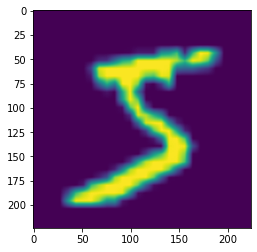

In [68]:
import torchvision.datasets as dsets
import matplotlib.pyplot as plt

Mnist_train = dsets.MNIST(root = "MNIST_data/", transform= trans)

# 내부의 데이터 확인하기
# dataset 자체에 대한 걸
for data in Mnist_train:
    imgs, label = data
    print(imgs,label)
    
    # 사진보기
    plt.imshow(imgs)
    
    # 사진을 Tensor type으로 보기
    t = transforms.ToTensor()(imgs)
    print(t.shape)
    
    
    break

t is:  torch.Size([1, 224, 224])


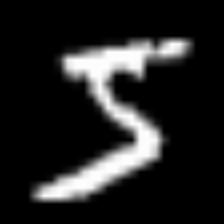

<PIL.Image.Image image mode=RGB size=224x224 at 0x7FB81EB5EE80>
(224, 224)


In [69]:
# Tensor type을 이미지로.
print("t is: ", t.size())
im = transforms.ToPILImage()(t).convert("RGB")
display(im)
print(im)
print(im.size)

# class

In [126]:
class test:
    def __init__(self):
        self.x = [1,2,3]
        print(self.x)

            
    def forward(self):
        for i in range(len(self.x)):
            self.x[i] += 1
        return self.x
    
t = test()

#t.forward()

[1, 2, 3]


In [118]:
def star(a : list):
    print(*a)
    

In [119]:
star([1,2,3])

1 2 3


In [169]:
class Downsample(nn.Module):
    def __init__(self, in_channel, out_channel):
        super(Downsample,self).__init__()
        self.layer = nn.Sequential(
                    nn.Conv2d(in_channel, out_channel, kernel_size= 1),
                    nn.BatchNorm2d(out_channel),
        )
        
    
    def forward(self,x):
        out = self.layer(x)
        return out
    
test_model = Downsample(16,24)
test_model      

Downsample(
  (layer): Sequential(
    (0): Conv2d(16, 24, kernel_size=(1, 1), stride=(1, 1))
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)

In [187]:
test_data = torch.Tensor(2,16,112,112)

Downsample(16,24)(test_data).shape

torch.Size([2, 24, 112, 112])